# eCommerce: Lade und analysiere alle DataFrames
Das Notebook **„day5_online_shop.ipynb“** ist ein Analyse-Notebook für **eCommerce-Daten** – konkret aus der *Maven Fuzzy Factory*-Datenbank.
Hier ist eine kurze Zusammenfassung, was es grundsätzlich macht und worum es geht:

---

### 🧠 **Ziel & Inhalt des Notebooks**

Das Notebook dient dazu, **verschiedene Datensätze eines Online-Shops zu laden, zu untersuchen und zu analysieren.**

Es automatisiert das:

1. **Einlesen** aller vorhandenen Daten (CSV, Excel, JSON, Parquet usw.) aus einem Verzeichnis (`work/data/eCommerce`),
2. **Erstellen von pandas DataFrames** für jede Tabelle (z. B. `website_sessions`, `order_items`, `products` usw.),
3. **Ausgeben von Übersichten und Statistiken** (z. B. Anzahl Zeilen/Spalten, Datentypen, Speicherbedarf),
4. **Durchführen erster Analysen**, etwa:

   * welches Produkt sich am besten verkauft,
   * Verknüpfung von Tabellen (z. B. Bestellungen mit Produkten),
   * und weitere Auswertungen.

---

### 🔍 **Wichtige Funktionen**

* `load_ecom_dfs(folder: Path)`: Lädt automatisch alle unterstützten Dateien im angegebenen Ordner als DataFrames in ein Dictionary.
* `summarize_df(df)`: Erstellt eine kompakte Zusammenfassung eines DataFrames (Größe, Spalten, Datentypen usw.).
* Anschließend werden alle geladenen Tabellen durchgegangen und kurz beschrieben.

---

### 📊 **Analysen im Notebook**

Spätere Abschnitte konzentrieren sich auf:

* Verkaufsanalysen (`order_items`, `products`),
* Website-Analysen (`website_sessions`),
* Marketing-Analysen (wahrscheinlich über `utm_campaign`, `utm_content` usw.),
* eventuell auch **Konversionspfade** und **Kampagnen-Performance**.


In [32]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Dict
import warnings
warnings.filterwarnings('ignore')

# Pfad zur eCommerce-Datenablage (im Container-Workdir)
ecom_folder = Path(os.path.join('work', 'data', 'eCommerce'))
print('eCommerce folder exists:', ecom_folder.exists(), '->', str(ecom_folder))

eCommerce folder exists: True -> work/data/eCommerce


## Funktion: Dateien finden und in DataFrames laden

In [6]:
def load_ecom_dfs(folder: Path) -> Dict[str, pd.DataFrame]:
    """Scan folder and load supported files into a dict of DataFrames keyed by filename (without ext)."""
    supported = ['.csv', '.json', '.xlsx', '.xls', '.parquet', '.pkl']
    dfs = {}
    if not folder.exists():
        print('Folder does not exist:', folder)
        return dfs
    for p in folder.iterdir():
        if not p.is_file():
            continue
        ext = p.suffix.lower()
        base = p.stem
        key = base
        try:
            if ext == '.csv':
                df = pd.read_csv(p)
            else:
                # unsupported
                continue
            dfs[key] = df
        except Exception as e:
            print(f'Failed to load {p.name}: {e}')
    return dfs

# Lade alle DataFrames
ecom_dfs = load_ecom_dfs(ecom_folder)
print('Loaded dataframes:', list(ecom_dfs.keys()))

Loaded dataframes: ['products', 'orders', 'website_sessions', 'maven_fuzzy_factory_data_dictionary', 'order_item_refunds', 'order_items', 'website_pageviews']


## Funktion: Kompakte Zusammenfassung eines DataFrames

In [8]:
def summarize_df(df: pd.DataFrame, n_head: int = 5) -> dict:
    """Return a small summary dict for a DataFrame."""
    mem = df.memory_usage(deep=True).sum()
    dtypes = df.dtypes.apply(lambda x: x.name).to_dict()
    missing = df.isna().sum().to_dict()
    missing_frac = {k: v / len(df) for k, v in missing.items()} if len(df) else {}
    nunique = df.nunique(dropna=False).to_dict()
    sample = df.head(n_head)
    desc = None
    try:
        desc = df.describe(include='all').to_dict()
    except Exception:
        desc = {}
    return {
        'rows': len(df),
        'cols': df.shape[1] if df is not None else 0,
        'memory_bytes': int(mem),
        'dtypes': dtypes,
        'nunique': nunique,
        'missing': missing,
        'missing_frac': missing_frac,
        'head': sample,
        'describe': desc
    }

## Übersichts-Report für alle geladenen DataFrames

In [9]:
from IPython.display import display

overview = []
for name, df in ecom_dfs.items():
    print('\n---', name, '---')
    s = summarize_df(df)
    print(f"shape: {s['rows']} x {s['cols']}")
    print(f"memory (MB): {s['memory_bytes']/1024**2:.2f}")
    # show top 5 dtypes
    dtype_counts = pd.Series(list(s['dtypes'].values())).value_counts().to_dict()
    print('dtypes:', dtype_counts)
    # show columns with most missing values
    missing_sorted = sorted(s['missing'].items(), key=lambda kv: kv[1], reverse=True)[:5]
    print('top missing cols (name, count):', missing_sorted)
    display(s['head'])
    overview.append({'name': name, 'rows': s['rows'], 'cols': s['cols'], 'memory_mb': s['memory_bytes']/1024**2})

overview_df = pd.DataFrame(overview)
display(overview_df)


--- products ---
shape: 4 x 3
memory (MB): 0.00
dtypes: {'object': 2, 'int64': 1}
top missing cols (name, count): [('product_id', 0), ('created_at', 0), ('product_name', 0)]


,product_id,created_at,product_name
0,1,2012-03-19 08:00:00,The Original Mr. Fuzzy
1,2,2013-01-06 13:00:00,The Forever Love Bear
2,3,2013-12-12 09:00:00,The Birthday Sugar Panda
3,4,2014-02-05 10:00:00,The Hudson River Mini bear



--- orders ---
shape: 32313 x 8
memory (MB): 4.07
dtypes: {'int64': 5, 'float64': 2, 'object': 1}
top missing cols (name, count): [('order_id', 0), ('created_at', 0), ('website_session_id', 0), ('user_id', 0), ('primary_product_id', 0)]


,order_id,created_at,website_session_id,user_id,primary_product_id,items_purchased,price_usd,cogs_usd
0,1,2012-03-19 10:42:46,20,20,1,1,49.99,19.49
1,2,2012-03-19 19:27:37,104,104,1,1,49.99,19.49
2,3,2012-03-20 06:44:45,147,147,1,1,49.99,19.49
3,4,2012-03-20 09:41:45,160,160,1,1,49.99,19.49
4,5,2012-03-20 11:28:15,177,177,1,1,49.99,19.49



--- website_sessions ---
shape: 472871 x 9
memory (MB): 187.05
dtypes: {'object': 6, 'int64': 3}
top missing cols (name, count): [('utm_source', 83328), ('utm_campaign', 83328), ('utm_content', 83328), ('http_referer', 39917), ('website_session_id', 0)]


,website_session_id,created_at,user_id,is_repeat_session,utm_source,utm_campaign,utm_content,device_type,http_referer
0,1,2012-03-19 08:04:16,1,0,gsearch,nonbrand,g_ad_1,mobile,https://www.gsearch.com
1,2,2012-03-19 08:16:49,2,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com
2,3,2012-03-19 08:26:55,3,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com
3,4,2012-03-19 08:37:33,4,0,gsearch,nonbrand,g_ad_1,desktop,https://www.gsearch.com
4,5,2012-03-19 09:00:55,5,0,gsearch,nonbrand,g_ad_1,mobile,https://www.gsearch.com



--- maven_fuzzy_factory_data_dictionary ---
shape: 36 x 3
memory (MB): 0.01
dtypes: {'object': 3}
top missing cols (name, count): [('Table', 0), ('Field', 0), ('Description', 0)]


,Table,Field,Description
0,orders,order_id,Unique identifier for each order (PK)
1,orders,created_at,Timestamp when the order was placed
2,orders,website_session_id,Unique identifier for the website session (FK)
3,orders,user_id,Unique identifier for the user (FK)
4,orders,primary_product_id,Unique identifier for the primary product in t...



--- order_item_refunds ---
shape: 1731 x 5
memory (MB): 0.18
dtypes: {'int64': 3, 'object': 1, 'float64': 1}
top missing cols (name, count): [('order_item_refund_id', 0), ('created_at', 0), ('order_item_id', 0), ('order_id', 0), ('refund_amount_usd', 0)]


,order_item_refund_id,created_at,order_item_id,order_id,refund_amount_usd
0,1,2012-04-06 11:32:43,57,57,49.99
1,2,2012-04-13 01:09:43,74,74,49.99
2,3,2012-04-15 07:03:48,71,71,49.99
3,4,2012-04-17 20:00:37,118,118,49.99
4,5,2012-04-22 20:53:49,116,116,49.99



--- order_items ---
shape: 40025 x 7
memory (MB): 4.73
dtypes: {'int64': 4, 'float64': 2, 'object': 1}
top missing cols (name, count): [('order_item_id', 0), ('created_at', 0), ('order_id', 0), ('product_id', 0), ('is_primary_item', 0)]


,order_item_id,created_at,order_id,product_id,is_primary_item,price_usd,cogs_usd
0,1,2012-03-19 10:42:46,1,1,1,49.99,19.49
1,2,2012-03-19 19:27:37,2,1,1,49.99,19.49
2,3,2012-03-20 06:44:45,3,1,1,49.99,19.49
3,4,2012-03-20 09:41:45,4,1,1,49.99,19.49
4,5,2012-03-20 11:28:15,5,1,1,49.99,19.49



--- website_pageviews ---
shape: 1188124 x 4
memory (MB): 181.35
dtypes: {'int64': 2, 'object': 2}
top missing cols (name, count): [('website_pageview_id', 0), ('created_at', 0), ('website_session_id', 0), ('pageview_url', 0)]


,website_pageview_id,created_at,website_session_id,pageview_url
0,1,2012-03-19 08:04:16,1,/home
1,2,2012-03-19 08:16:49,2,/home
2,3,2012-03-19 08:26:55,3,/home
3,4,2012-03-19 08:37:33,4,/home
4,5,2012-03-19 09:00:55,5,/home


,name,rows,cols,memory_mb
0,products,4,3,0.000752
1,orders,32313,8,4.067848
2,website_sessions,472871,9,187.047750
3,maven_fuzzy_factory_data_dictionary,36,3,0.008253
4,order_item_refunds,1731,5,0.178413
5,order_items,40025,7,4.733307
6,website_pageviews,1188124,4,181.349192


## Finde heraus welches das best laufendste Produkt ist

In [11]:
best_selling = (
    ecom_dfs['order_items']['product_id']
    .value_counts()
    .rename_axis('product_id')
    .reset_index(name='qty')
    .merge(ecom_dfs['products'][['product_id','product_name']], on='product_id', how='left')
    .sort_values('qty', ascending=False)
    .head(5)
)
display(best_selling)

,product_id,qty,product_name
0,1,24226,The Original Mr. Fuzzy
1,2,5796,The Forever Love Bear
2,4,5018,The Hudson River Mini bear
3,3,4985,The Birthday Sugar Panda


## Finde heraus welches mit welchem Produkt am meisten Umsatz gemacht wurde? 

In [13]:
# Gruppiere die Bestellpositionen nach Produkt und summiere den Preis, um den Gesamtumsatz pro Produkt zu berechnen
revenue_per_product = (
    ecom_dfs['order_items']
    .groupby('product_id')['price_usd']
    .sum()
    .reset_index(name='total_revenue')  # Setze das Ergebnis als DataFrame mit Spalte 'total_revenue'
    .merge(
        ecom_dfs['products'][['product_id', 'product_name']],  # Füge Produktnamen hinzu
        on='product_id',
        how='left'
    )
    .sort_values('total_revenue', ascending=False)  # Sortiere nach Umsatz absteigend
    .head(5)  # Zeige die Top 5 Produkte mit dem meisten Umsatz
)
display(revenue_per_product)  # Zeige das Ergebnis an

,product_id,total_revenue,product_name
0,1,1211057.74,The Original Mr. Fuzzy
1,2,347702.04,The Forever Love Bear
2,3,229260.15,The Birthday Sugar Panda
3,4,150489.82,The Hudson River Mini bear


## Finde über das Dataframe website_sessions heraus von welchen websiten der Traffic kommt und visualisiere diesen. 

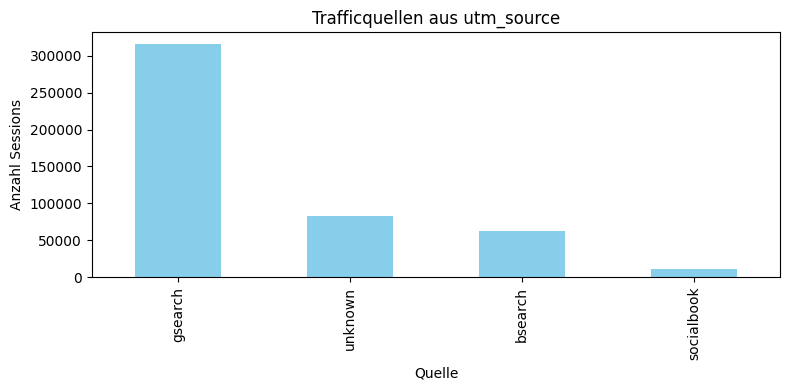

utm_source
gsearch       316035
unknown        83328
bsearch        62823
socialbook     10685
Name: count, dtype: int64

In [14]:
# Analysiere die Herkunft des Traffics aus website_sessions und visualisiere sie
import matplotlib.pyplot as plt

if 'website_sessions' in ecom_dfs:
    ws = ecom_dfs['website_sessions']
    # Prüfe, welche Spalte die Quelle enthält (häufig: 'utm_source', 'referrer', o.ä.)
    traffic_col = None
    for col in ['utm_source', 'referrer', 'source', 'traffic_source']:
        if col in ws.columns:
            traffic_col = col
            break
    if traffic_col:
        traffic_counts = ws[traffic_col].fillna('unknown').value_counts()
        traffic_counts.plot(kind='bar', figsize=(8,4), color='skyblue')
        plt.title(f'Trafficquellen aus {traffic_col}')
        plt.xlabel('Quelle')
        plt.ylabel('Anzahl Sessions')
        plt.tight_layout()
        plt.show()
        display(traffic_counts)
    else:
        print('Keine offensichtliche Spalte für Trafficquelle gefunden.')
else:
    print('DataFrame website_sessions nicht geladen.')

## Analyse: Zeit bis zur Bestellung vs. Bestellwert

Wir untersuchen den Zusammenhang zwischen der Zeit, die ein Kunde bis zum Kauf braucht, und dem Gesamtwert seiner Bestellung. Die Analyse wird in mehrere Schritte aufgeteilt.

### Schritt 1: Gruppierung der Bestellungen nach Session
Zuerst gruppieren wir alle Bestellungen nach ihrer Session-ID und berechnen den Gesamtwert pro Session sowie den Zeitpunkt der ersten Bestellung in dieser Session.

In [17]:
# Gruppiere Orders nach Sessions und summiere die Preise
session_orders = (
    ecom_dfs['orders']
    .groupby('website_session_id')
    .agg({
        'price_usd': 'sum',
        'created_at': 'first'  # Zeitpunkt der ersten Bestellung in der Session
    })
    .reset_index()
)
display(session_orders.head())

,website_session_id,price_usd,created_at
0,20,49.99,2012-03-19 10:42:46
1,104,49.99,2012-03-19 19:27:37
2,147,49.99,2012-03-20 06:44:45
3,160,49.99,2012-03-20 09:41:45
4,177,49.99,2012-03-20 11:28:15


### Schritt 2: Verknüpfung mit Session-Daten
Nun verbinden wir die gruppierten Bestelldaten mit den Session-Informationen, um den Startzeitpunkt jeder Session zu erhalten.

In [18]:
# Verbinde mit Session-Daten
merged_data = (
    session_orders.merge(
        ecom_dfs['website_sessions'][['website_session_id', 'created_at']],
        on='website_session_id',
        suffixes=('_order', '_session')
    )
)
display(merged_data.head())

,website_session_id,price_usd,created_at_order,created_at_session
0,20,49.99,2012-03-19 10:42:46,2012-03-19 10:22:58
1,104,49.99,2012-03-19 19:27:37,2012-03-19 19:14:04
2,147,49.99,2012-03-20 06:44:45,2012-03-20 06:21:56
3,160,49.99,2012-03-20 09:41:45,2012-03-20 09:23:55
4,177,49.99,2012-03-20 11:28:15,2012-03-20 11:15:15


### Schritt 3: Berechnung der Zeitdifferenz
Wir berechnen die Zeit zwischen Session-Start und Bestellung in Minuten.

In [19]:
# Konvertiere Zeitstempel und berechne Differenz in Minuten
merged_data['created_at_order'] = pd.to_datetime(merged_data['created_at_order'])
merged_data['created_at_session'] = pd.to_datetime(merged_data['created_at_session'])
merged_data['time_to_purchase_min'] = (
    (merged_data['created_at_order'] - merged_data['created_at_session'])
    .dt.total_seconds() / 60
)
display(merged_data[['website_session_id', 'time_to_purchase_min', 'price_usd']].head())

,website_session_id,time_to_purchase_min,price_usd
0,20,19.800000,49.99
1,104,13.550000,49.99
2,147,22.816667,49.99
3,160,17.833333,49.99
4,177,13.000000,49.99


### Schritt 4: Visualisierung und Analyse
Zum Schluss erstellen wir ein Streudiagramm mit Trendlinie, um den Zusammenhang zwischen Bestellzeit und Bestellwert zu visualisieren.

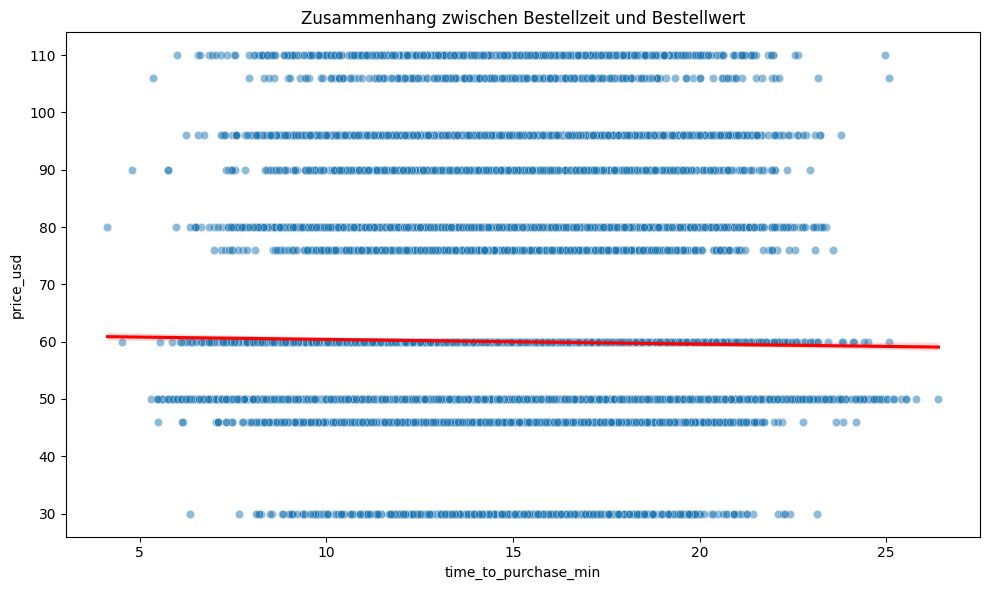


Statistische Kennzahlen:
       time_to_purchase_min     price_usd
count          32313.000000  32313.000000
mean              14.954240     59.991636
std                3.107609     17.808771
min                4.133333     29.990000
25%               12.783333     49.990000
50%               14.950000     49.990000
75%               17.100000     59.990000
max               26.400000    109.980000


In [ ]:
# Visualisierung
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='time_to_purchase_min',
    y='price_usd',
    alpha=0.5
)
plt.title('Zusammenhang zwischen Bestellzeit und Bestellwert')
plt.xlabel('Zeit bis zur Bestellung (Minuten)')
plt.ylabel('Bestellwert (USD)')

# Füge Trendlinie hinzu
sns.regplot(
    data=merged_data,
    x='time_to_purchase_min',
    y='price_usd',
    scatter=False,
    color='red'
)

plt.tight_layout()
plt.show()

## Zeige dir das Komplette Data Dictionary an um herauszufinden, welche Kampagnen und ad/content Strategien gefahren wurden

In [33]:
ecom_dfs["maven_fuzzy_factory_data_dictionary"]

,Table,Field,Description
0,orders,order_id,Unique identifier for each order (PK)
1,orders,created_at,Timestamp when the order was placed
2,orders,website_session_id,Unique identifier for the website session (FK)
3,orders,user_id,Unique identifier for the user (FK)
4,orders,primary_product_id,Unique identifier for the primary product in t...
5,orders,items_purchased,Number of items in the order
6,orders,price_usd,Total price for the items in the order
7,orders,cogs_usd,Cost of goods sold for the items in the order
8,order_items,order_item_id,Unique identifier for each order item (PK)
9,order_items,created_at,Timestamp when the order was placed


In [34]:
# Alle eindeutigen Werte (Kategorien) in utm_campaign und utm_content anzeigen
website_sessions = ecom_dfs.get('website_sessions')
print("Kategorien in utm_campaign:")
print(website_sessions['utm_campaign'].dropna().unique())

print("\nKategorien in utm_content:")
print(website_sessions['utm_content'].dropna().unique())

Kategorien in utm_campaign:
['nonbrand' 'brand' 'pilot' 'desktop_targeted']

Kategorien in utm_content:
['g_ad_1' 'g_ad_2' 'b_ad_2' 'b_ad_1' 'social_ad_1' 'social_ad_2']


## Nutze die Daten von oben mit denen der Durchschnittliche Warenkorb erstellt wurde und füge diesmal die Kampagne und die ad/content variante hinzu

In [ ]:
# Verbinde mit Session-Daten campaign und content
merged_data = (
    session_orders.merge(
        ecom_dfs['website_sessions'][['website_session_id', 'created_at', 'utm_campaign', 'utm_content']],
        on='website_session_id',
        suffixes=('_order', '_session')
    )
)
display(merged_data.head())

,website_session_id,price_usd,created_at_order,created_at_session,utm_campaign,utm_content
0,20,49.99,2012-03-19 10:42:46,2012-03-19 10:22:58,nonbrand,g_ad_1
1,104,49.99,2012-03-19 19:27:37,2012-03-19 19:14:04,nonbrand,g_ad_1
2,147,49.99,2012-03-20 06:44:45,2012-03-20 06:21:56,nonbrand,g_ad_1
3,160,49.99,2012-03-20 09:41:45,2012-03-20 09:23:55,nonbrand,g_ad_1
4,177,49.99,2012-03-20 11:28:15,2012-03-20 11:15:15,nonbrand,g_ad_1


## Visualisere welche wirkung die Einzelnen Kampagnen haben

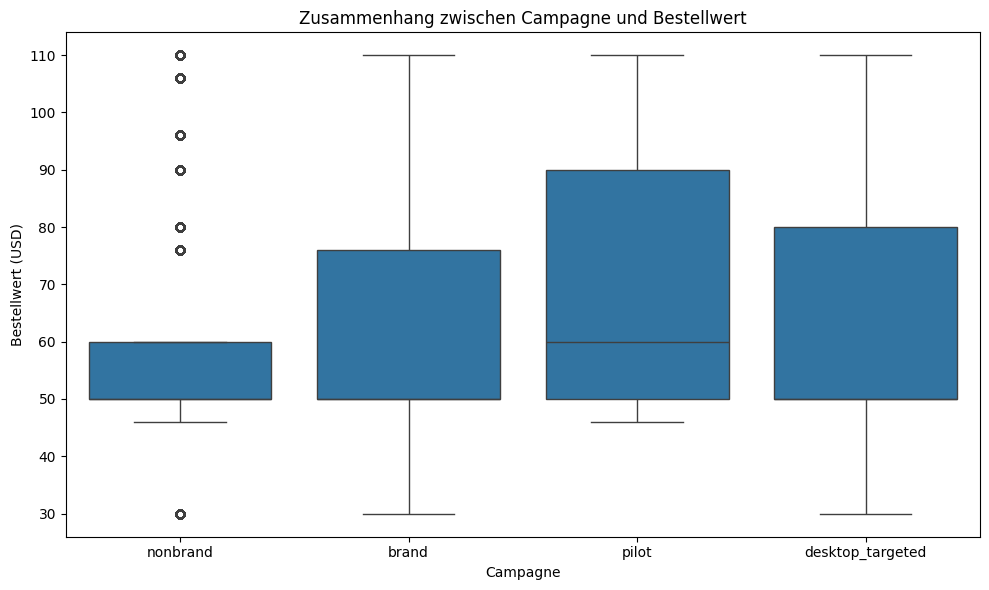

In [29]:
# Visualisierung
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merged_data,
    x='utm_campaign',
    y='price_usd'
)
plt.title('Zusammenhang zwischen Campagne und Bestellwert')
plt.xlabel('Campagne')
plt.ylabel('Bestellwert (USD)')

plt.tight_layout()
plt.show()

## Visualisiere den welche wirkung die einzelnen Webungen haben

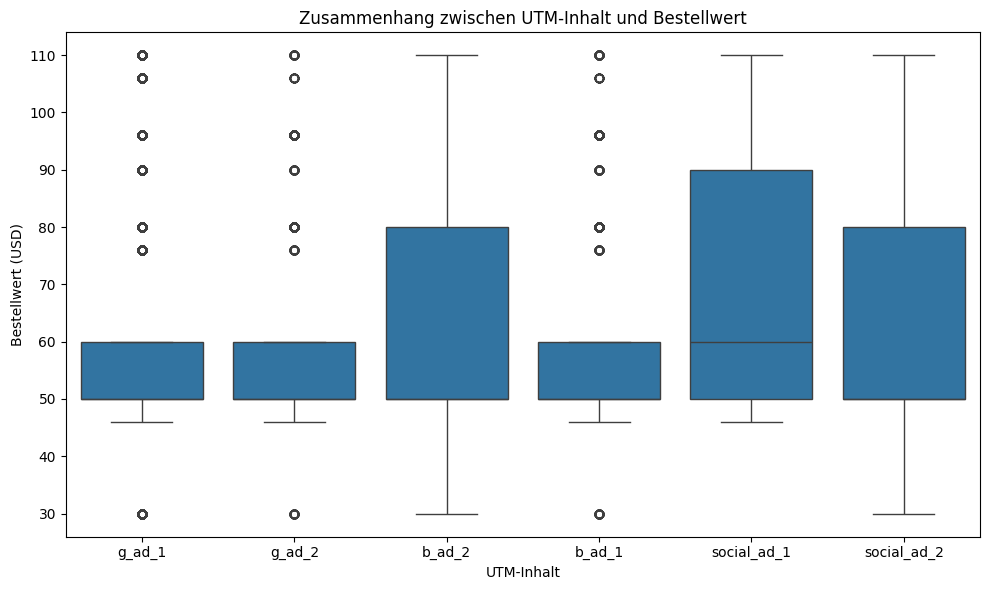

In [30]:
# Visualisierung
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merged_data,
    x='utm_content',
    y='price_usd'
)
plt.title('Zusammenhang zwischen UTM-Inhalt und Bestellwert')
plt.xlabel('UTM-Inhalt')
plt.ylabel('Bestellwert (USD)')

plt.tight_layout()
plt.show()